In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
# Parameters
num_epochs = 30
batch_size = 64
learning_rate = 0.001
T = 40  # Number of diffusion steps

# Transformations and Data Loading
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# Define the Model
class DiffusionModel(nn.Module):
    def __init__(self):
        super(DiffusionModel, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, x, T, betas):
        x = x.view(-1, 28*28)
        original_x = x.clone()
        for t in range(T):
            noise = torch.randn_like(x)
            x = x.clone().detach() + torch.sqrt(betas[t]) * noise

        reconstructed = self.decoder(x)/2 + 0.5
        return reconstructed.view(-1, 1, 28, 28), original_x.view(-1, 1, 28, 28)

    def sample(self, batch_size, device):
        x = torch.randn(batch_size, 28*28, device=device)  # Sample from a normal distribution
        return self.decoder(x).view(-1, 1, 28, 28)/2 + 0.5

# Initialize the model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DiffusionModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()


In [ ]:
# Training Loop
for epoch in range(num_epochs):
    for images, _ in train_loader:
        images = images.to(device)
        betas = torch.linspace(0.001, 0.01, T).to(device)
        reconstructed_images, original_images = model(images, T, betas)
        loss = criterion(reconstructed_images, original_images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/30], Loss: 0.0214
Epoch [2/30], Loss: 0.0170
Epoch [3/30], Loss: 0.0150
Epoch [4/30], Loss: 0.0144
Epoch [5/30], Loss: 0.0118
Epoch [6/30], Loss: 0.0124
Epoch [7/30], Loss: 0.0137
Epoch [8/30], Loss: 0.0116
Epoch [9/30], Loss: 0.0107
Epoch [10/30], Loss: 0.0132
Epoch [11/30], Loss: 0.0129
Epoch [12/30], Loss: 0.0110
Epoch [13/30], Loss: 0.0119
Epoch [14/30], Loss: 0.0127
Epoch [15/30], Loss: 0.0114
Epoch [16/30], Loss: 0.0123
Epoch [17/30], Loss: 0.0118
Epoch [18/30], Loss: 0.0119
Epoch [19/30], Loss: 0.0118
Epoch [20/30], Loss: 0.0115
Epoch [21/30], Loss: 0.0112
Epoch [22/30], Loss: 0.0119
Epoch [23/30], Loss: 0.0119
Epoch [24/30], Loss: 0.0113
Epoch [25/30], Loss: 0.0102
Epoch [26/30], Loss: 0.0131
Epoch [27/30], Loss: 0.0113
Epoch [28/30], Loss: 0.0104
Epoch [29/30], Loss: 0.0105
Epoch [30/30], Loss: 0.0103


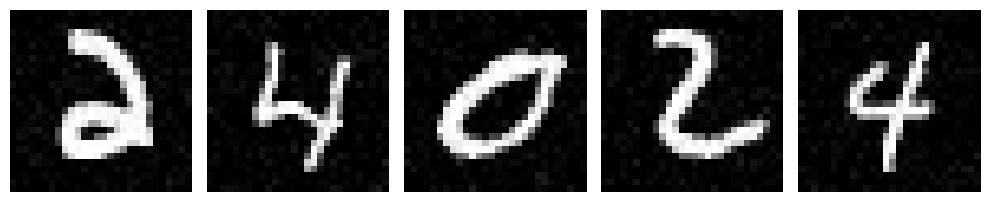

In [ ]:
# Sampling and Visualization
with torch.no_grad():
    sampled_images = model.sample(5, device)

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, img in enumerate(sampled_images):
    axs[i].imshow(img.squeeze().cpu(), cmap='gray')
    axs[i].axis('off')
plt.show()

